In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keybert
!python -m spacy download en_core_web_md
!pip install flair
!pip install textacy
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import spacy
import re
nlp = spacy.load("en_core_web_sm")
import textacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from keybert import KeyBERT
from flair.data import Sentence
from flair.models import SequenceTagger
ner_tagger = SequenceTagger.load("flair/ner-english")
pos_tagger = SequenceTagger.load("flair/pos-english")
with open("/content/drive/MyDrive/Mencius_research/Mencius_research/extra_stopwords.txt", 'rt') as f:
  extra_stopword_list = [t.replace("\n",'') for t in f.readlines()]
stop_words = list(set(stopwords.words('english')))+extra_stopword_list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 237 kB 42.2 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 
     |████████████████████████████████| 5.8 MB 73.5 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
     |████████████████████████████████| 182 kB 73.7 MB/s 
     |████████████████████████████████| 7.6 MB 68.8 MB/s 
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23800 sha256=197dd7ff2731d186ed97d3327200921aee4013e681ac12c2c02a75a65d2c09a8
  Stored in directory: /root/.cache/pip/wheels/6c/bc/8b/a51bee77aec33895e6c8c236144b4cc10875659c4d2c80f070
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2a28f307e516ba7fb8e492cd41f05efe4885a50352f0b1da4bf4ac1923946e2f
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloa

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

2022-12-27 14:53:15,926 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-12-27 14:53:18,258 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

2022-12-27 14:53:28,942 loading file /root/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63
2022-12-27 14:53:29,103 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


## 파일 불러오기

In [ ]:
#맹자남은부분-파란색
with open("/content/drive/MyDriveMencius_research/Mencius_research/not_deleted_dict_structure.pickle",'rb') as f:
 mencius_not_deleted = pickle.load(f)

#맹자삭제된부분-빨간색
with open("/content/drive/MyDrive/Mencius_research/Mencius_research/deleted_dict_structure.pickle",'rb') as f:
 mencius_deleted = pickle.load(f)

## 삭제 안 된 부분 전처리 후 빈도분석

In [ ]:
not_deleted_text = '' #삭제안한부분에 대한 모든 내용
for t in mencius_not_deleted.keys():
  for k in mencius_not_deleted[t].keys():
    for j,v in mencius_not_deleted[t][k].items():
      not_deleted_text += ' '+v


# 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
roman = list(mencius_not_deleted.keys()) #I, II, III, IV...
for r in roman:
  not_deleted_text = re.sub(f'\\b{r}\\b',' ',not_deleted_text)
mid_heading = []                         #Gong Sun Chou I, ... 
for k in mencius_not_deleted.keys():
  mid_heading.extend(list(mencius_not_deleted[k].keys()))
for m in mid_heading:
  not_deleted_text = re.sub(f'\\b{m}\\b',' ',not_deleted_text)
not_deleted_text = not_deleted_text.replace('·',' ').strip()  #불필요한 특수기호

In [ ]:
#개체명인식을 이용하여 사람 이름을 모두 제거
sentence = Sentence(not_deleted_text)
ner_tagger.predict(sentence)
ner_tagged=[(label.data_point.text, label.value) for label in sentence.get_labels('ner')]
per_tagged = [(tup[0],tup[1]) for tup in ner_tagged if tup[1]=='PER']
per_tagged = [tup[0] for tup in per_tagged]
per_tagged_name = list(set(per_tagged)) #['Yi Yin', 'Gong Ming Gao', 'Ding']

not_deleted_text
for p in per_tagged_name:
  not_deleted_text = not_deleted_text.replace(p,'')

In [ ]:
#전체 텍스트 소문자 변환
not_deleted_text = not_deleted_text.lower()

In [ ]:
#동의어 통일
not_deleted_text = re.sub(r'\bduke\b|\bmajesty(\'s|s)?\b|\bson of heaven\b|\b(royal\s*)?sovereigns?\b|\bprince(\s*of\s*ten\s*thousand\s*chariots|s)?\b|\b(royal\s*)?ruler\b|\bmonarchs?\b|\b(royal\s*)?kings?\b','king',not_deleted_text)
not_deleted_text = re.sub(r'\bfillial\s*piety\b','fillial',not_deleted_text)
not_deleted_text = re.sub(r'\b(little|small|country|inferior|low)\s*(m(e|a)n|people)\b','inferior man',not_deleted_text)
not_deleted_text = re.sub(r'\b(high\s*)?ministers?\b|\bofficers?\b','officer',not_deleted_text)
not_deleted_text = re.sub(r'\bstates?\b|\bgovernments?\b|\b(kingdom|country)\s*of\s*ten\s*thousand\s*chariots\b','kingdom',not_deleted_text)
not_deleted_text = not_deleted_text.replace('viscount','noble').replace('country','kingdom')
not_deleted_text = re.sub(r'\bsuperior\s*m(a|e)n\b|\bgood\s*m(a|e)n\b|\bmen\s*of\s*a\s*superior\s*grade\b','superior man',not_deleted_text)
not_deleted_text = re.sub(r'\bmen\b|\bwomen\b','people',not_deleted_text)
not_deleted_text = re.sub(r'\breign\b|\bgovern\b|\bt(ook|ake)\s*office','govern',not_deleted_text)

#명사구 추출
doc=nlp(not_deleted_text)
patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
noun_phrase=[s.lemma_ for s in spans]
noun_phrase=list(set(noun_phrase))
for n in noun_phrase:
  phrase=str(n).replace(" ","-")
  not_deleted_text = re.sub(f"\\b{n}\\b", phrase, not_deleted_text)

In [ ]:
#토큰화
not_deleted_text = word_tokenize(not_deleted_text)

In [ ]:
#형태소 분석 - 형용사, 명사, 동사 단어만 추출
def new_pos_tagger(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV

not_deleted_text = nltk.pos_tag(not_deleted_text)
not_deleted_text = list(map(lambda x: (x[0], new_pos_tagger(x[1])), not_deleted_text))
not_deleted_text = [w for w, t in not_deleted_text if t in ['n','a','v']]


In [ ]:
#표제어 추출
lemmatized_text = []
for w in not_deleted_text:
  if '-' in w:
    word = w.replace("-",'')
    lemmatized_text.append(word)
  else:
    for tok in nlp(w):
      lemmatized_text.append(tok.lemma_)
not_deleted_text = [str(w) for w in lemmatized_text]

In [ ]:
#불용어 제거
not_deleted_text = [w for w in not_deleted_text if w not in stop_words]
not_deleted_text = ' '.join(not_deleted_text)
not_deleted_text = re.sub(r'(much|more|most)','',not_deleted_text)
not_deleted_text = word_tokenize(not_deleted_text)

In [ ]:
fdist = nltk.FreqDist(not_deleted_text)
fdist.most_common(15)

[('king', 223),
 ('people', 208),
 ('kingdom', 138),
 ('principle', 59),
 ('good', 55),
 ('parent', 55),
 ('superiorman', 54),
 ('righteousness', 52),
 ('scholar', 47),
 ('water', 47),
 ('great', 44),
 ('love', 43),
 ('officer', 43),
 ('benevolence', 42),
 ('nature', 42)]

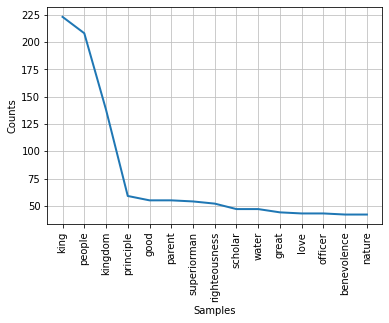

In [ ]:
fdist.plot(15)

In [ ]:
word_freq_dic={k[0]:k[1] for k in fdist.most_common(15)}

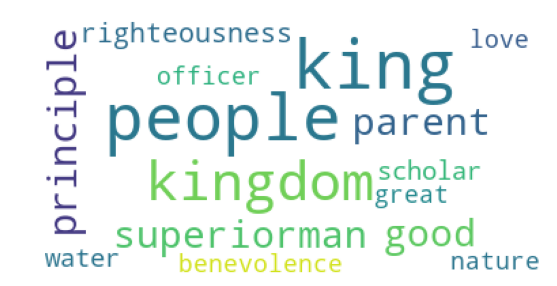

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(max_font_size = 50, max_words = 15, background_color = 'white')
wc = wc.generate_from_frequencies(word_freq_dic)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

## 삭제된 부분 전처리 후 빈도분석

In [ ]:
deleted_text = '' #삭제안한부분에 대한 모든 내용
for t in mencius_deleted.keys():
  for k in mencius_deleted[t].keys():
    for j,v in mencius_deleted[t][k].items():
      deleted_text += ' '+v

# 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
roman = list(mencius_deleted.keys()) #I, II, III, IV...
for r in roman:
  deleted_text = re.sub(f'\\b{r}\\b',' ',deleted_text)
mid_heading = []                         #Gong Sun Chou I, ... 
for k in mencius_deleted.keys():
  mid_heading.extend(list(mencius_deleted[k].keys()))
for m in mid_heading:
  deleted_text = re.sub(f'\\b{m}\\b',' ',deleted_text)
deleted_text = deleted_text.replace('·',' ').strip()  #불필요한 특수기호

In [ ]:
#개체명인식을 이용하여 사람 이름을 모두 제거
sentence = Sentence(deleted_text)
ner_tagger.predict(sentence)
ner_tagged=[(label.data_point.text, label.value) for label in sentence.get_labels('ner')]
per_tagged = [(tup[0],tup[1]) for tup in ner_tagged if tup[1]=='PER']
per_tagged = [tup[0] for tup in per_tagged]
per_tagged_name = list(set(per_tagged)) #['Yi Yin', 'Gong Ming Gao', 'Ding']

deleted_text
for p in per_tagged_name:
  deleted_text = deleted_text.replace(p,'')

In [ ]:
#전체 텍스트 소문자 변환
deleted_text = deleted_text.lower()

In [ ]:
#동의어 통일
deleted_text = re.sub(r'\bduke\b|\bmajesty(\'s|s)?\b|\bson of heaven\b|\b(royal\s*)?sovereigns?\b|\bprince(\s*of\s*ten\s*thousand\s*chariots|s)?\b|\b(royal\s*)?ruler\b|\bmonarchs?\b|\b(royal\s*)?kings?\b','king',deleted_text)
deleted_text = re.sub(r'\bfillial\s*piety\b','fillial',deleted_text)
deleted_text = re.sub(r'\b(little|small|country|inferior|low)\s*(m(e|a)n|people)\b','inferior man',deleted_text)
deleted_text = re.sub(r'\b(high\s*)?ministers?\b|\bofficers?\b','officer',deleted_text)
deleted_text = re.sub(r'\bstates?\b|\bgovernments?\b|\b(kingdom|country)\s*of\s*ten\s*thousand\s*chariots\b','kingdom',deleted_text)
deleted_text = deleted_text.replace('viscount','noble').replace('country','kingdom')
deleted_text = re.sub(r'\bsuperior\s*m(a|e)n\b|\bgood\s*m(a|e)n\b|\bmen\s*of\s*a\s*superior\s*grade\b','superior man',deleted_text)
deleted_text = re.sub(r'\bmen\b|\bwomen\b','people',deleted_text)
deleted_text = re.sub(r'\breign\b|\bgovern\b|\bt(ook|ake)\s*office','govern',deleted_text)

#명사구 추출
doc=nlp(deleted_text)
patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
noun_phrase=[s.lemma_ for s in spans]
noun_phrase=list(set(noun_phrase))
for n in noun_phrase:
  phrase=str(n).replace(" ","-")
  deleted_text = re.sub(f"\\b{n}\\b", phrase, deleted_text)

In [ ]:
#토큰화
deleted_text = word_tokenize(deleted_text)

In [ ]:
#형태소 분석
def new_pos_tagger(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV

deleted_text = nltk.pos_tag(deleted_text)
deleted_text = list(map(lambda x: (x[0], new_pos_tagger(x[1])), deleted_text))
deleted_text = [w for w, t in deleted_text if t in ['n','a','v']]

In [ ]:
#형용사, 명사, 부사 단어에 대한 표제어 추출
lemmatized_text = []
for w in deleted_text:
  if '-' in w:
    word = w.replace("-",'')
    lemmatized_text.append(word)
  else:
    for tok in nlp(w):
      lemmatized_text.append(tok.lemma_)
deleted_text = [str(w) for w in lemmatized_text]

In [ ]:
#불용어 제거
deleted_text = [w for w in deleted_text if w not in stop_words]
deleted_text = ' '.join(deleted_text)
deleted_text = re.sub(r'(much|more|most)','',deleted_text)
deleted_text = word_tokenize(deleted_text)

In [ ]:
fdist = nltk.FreqDist(deleted_text)
fdist.most_common(15)

[('king', 443),
 ('people', 220),
 ('kingdom', 161),
 ('officer', 63),
 ('hear', 41),
 ('virtue', 38),
 ('son', 37),
 ('benevolence', 35),
 ('receive', 33),
 ('word', 31),
 ('righteousness', 31),
 ('death', 30),
 ('office', 30),
 ('scholar', 30),
 ('send', 29)]

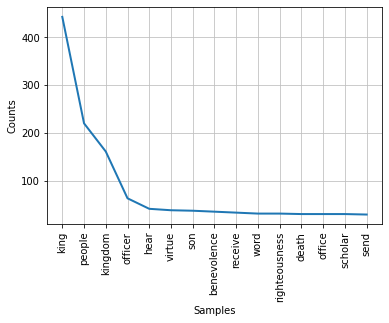

In [ ]:
fdist.plot(15)

In [ ]:
word_freq_dic={k[0]:k[1] for k in fdist.most_common(15)}

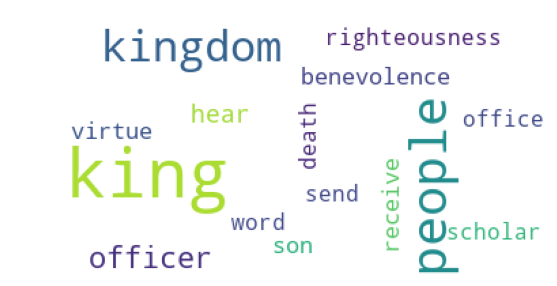

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(max_font_size = 50, max_words = 15, background_color = 'white')
wc = wc.generate_from_frequencies(word_freq_dic)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# 두 텍스트의 고빈도 어휘 비교 - 각 텍스트에서 공통 어휘와 공통 어휘를 제외한 나머지 어휘를 분석
del_fdist = nltk.FreqDist(deleted_text)
del_fdist_list = [freq[0] for freq in del_fdist.most_common(15)]
notdel_fdist = nltk.FreqDist(not_deleted_text)
notdel_fdist_list = [freq[0] for freq in notdel_fdist.most_common(15)]

common_words = set(del_fdist_list) & set(notdel_fdist_list)   # 공통 어휘
only_del = set(del_fdist_list) - common_words                 # 삭제된 부분에서 공통 어휘를 제외한 나머지 어휘
only_not_del = set(notdel_fdist_list) - common_words          # 삭제되지 않은 부분에서 공통 어휘를 제외한 나머지 어휘



In [ ]:
# 공통 어휘
list(common_words)

['officer',
 'king',
 'benevolence',
 'scholar',
 'righteousness',
 'kingdom',
 'people']

In [ ]:
# 삭제되지 않은 부분에서 공통 어휘를 제외한 나머지 어휘
only_not_del

{'good',
 'great',
 'love',
 'nature',
 'parent',
 'principle',
 'superiorman',
 'water'}

In [ ]:
# 삭제된 부분에서 공통 어휘를 제외한 나머지 어휘
only_del

{'death', 'hear', 'office', 'receive', 'send', 'son', 'virtue', 'word'}

### 공통 어휘에 대한 텍스트별 빈도수 비교

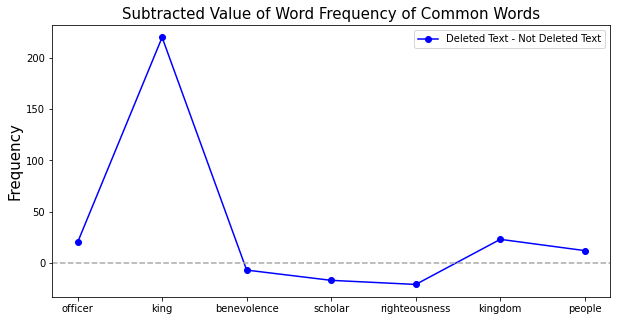

In [ ]:
common_words_list = list(common_words)

fdist = nltk.FreqDist(deleted_text)
deleted_tup=[(t[0],t[1]) for t in fdist.most_common(15) if t[0] in common_words_list]
fdist = nltk.FreqDist(not_deleted_text)
not_deleted_tup=[(t[0],t[1]) for t in fdist.most_common(15) if t[0] in common_words_list]

not_deleted_freq = []
for w in common_words_list:
  for tup in not_deleted_tup:
    if tup[0] == w:
      not_deleted_freq.append(tup[1])
deleted_freq = []
for w in common_words_list:
  for tup in deleted_tup:
    if tup[0] == w:
      deleted_freq.append(tup[1])

subtracted_value=[a-b for a, b in zip(deleted_freq, not_deleted_freq)]

plt.figure(figsize=(10,5))
# plt.plot(common_words_list, deleted_freq, color='red', marker='o')
# plt.plot(common_words_list, not_deleted_freq, color='green', marker='o')
# plt.legend(['deleted_freq','not_deleted_freq'])
# plt.ylabel('Frequency',fontdict={'fontsize':15})
# plt.title('Word Frequency of Common Words', fontdict={'fontsize':15})
# plt.show()
plt.plot(common_words_list, subtracted_value, color='blue',marker='o')
plt.legend(['Deleted Text - Not Deleted Text'])
plt.ylabel('Frequency',fontdict={'fontsize':15})
plt.axhline(0, color='#AAAAAA',linestyle='--')
plt.title('Subtracted Value of Word Frequency of Common Words', fontdict={'fontsize':15})
plt.show()